# Neural Model - Gaussian Filtering Step

In this notebook we present a first implementation of a neural model for sound source elevation estimation based on the computational HRTF model. In particular we demonstrate the neural model's ability to resemble the HRTF model's Gaussian filtering step. This is achieved by a local response normalization via feedforward inhibition and by changing the differential equation on the first neuron $r^{in}$ from 

\begin{equation}
 \tau \dot r^{in}_\omega = - \alpha \cdot r_\omega + (\beta - r_\omega) \cdot {EX}_{in} - \kappa \cdot r_\omega \cdot {In}_{in}
\end{equation}

to

\begin{equation}
 \tau \dot r^{in}_\omega = - \alpha \cdot r_\omega \cdot {EX}_{in}  + (\beta - r_\omega) \cdot {EX}_{in} - \kappa \cdot r_\omega \cdot {In}_{in}
\end{equation}

to dynamically adapt the decay rate $\alpha$. 

Results show the mode output of the $r^{in}$ neuron in comparison with the actual Gaussian filtering step.

In [1]:
# Import necessary modules
from pathlib import Path
from src.data import generateData
from src.features import helpers as hp
from src.visualization import helpers as hpVis
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d,convolve1d

ROOT = Path(os.getcwd()).resolve().parents[0]

SOUND_FILES = ROOT / 'data/raw/sound_samples/'
# create a list of the sound files
SOUND_FILES = list(SOUND_FILES.glob('**/*.wav'))

In [2]:
############################################################
#                    Helper functions                      #
############################################################

def process_inputs(psd_all_i, psd_all_c, ear='ipsi', normalization_type='sum_1', sigma_smoothing=0, sigma_gauss_norm=1):
    # filter the data
    psd_mono_c = hp.filter_dataset(psd_all_c, normalization_type=normalization_type,
                                   sigma_smoothing=sigma_smoothing, sigma_gauss_norm=sigma_gauss_norm)
    psd_mono_i = hp.filter_dataset(psd_all_i, normalization_type=normalization_type,
                                   sigma_smoothing=sigma_smoothing, sigma_gauss_norm=sigma_gauss_norm)

    # integrate the signals and filter
    if ear.find('contra') >= 0:
        psd_binaural = hp.filter_dataset(
            psd_mono_c / psd_mono_i, normalization_type=normalization_type, sigma_smoothing=0, sigma_gauss_norm=0)
    else:
        psd_binaural = hp.filter_dataset(
            psd_mono_i / psd_mono_c, normalization_type=normalization_type, sigma_smoothing=0, sigma_gauss_norm=0)

    # calculate different input sounds. should be 4 of them (mono,mono-mean,bin, bin-mean)
    if ear.find('contra') >= 0:
        psd_mono = psd_mono_c
    else:
        psd_mono = psd_mono_i

    psd_mono_mean = psd_mono - \
        np.transpose(np.tile(np.mean(psd_mono, axis=1), [
                     psd_mono.shape[1], 1, 1]), [1, 0, 2])
    psd_binaural = psd_binaural
    psd_binaural_mean = psd_binaural - \
        np.transpose(np.tile(np.mean(psd_binaural, axis=1), [
                     psd_binaural.shape[1], 1, 1]), [1, 0, 2])

    return psd_mono, psd_mono_mean, psd_binaural, psd_binaural_mean



In [3]:
############################################################
#                  Simulation functions                    #
############################################################

tau = 0.005

# Defines the output transfer function of q_A_SC 
def out_thres(q,threshold = 0.0,slope=1):    
    return np.minimum(np.maximum((q-threshold)*slope,0),1)

   
# Defines the sigmoidal transfer function  
def out_sigmoid(x,slope =5,operation_point=0.0):
#     return 1 / (1 + np.exp(-(x-working_point)*slope) ) 
    tmp = (x-operation_point)*slope
    return (2 / (1 + np.exp(-4*tmp**2)))-1


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        tmp = np.exp(-(x-mean)**2 /( 2 * sigma**2 ))
        return tmp/np.max(tmp)
    
# define the ODE for inhibitory input neurons
def ode_p_in(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha=1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for gaussian filter neurons
def ode_r_in(r,excitatory_in,inhibitory_in):
    # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 200
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0.0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 200
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in  + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r / tau



### Parameters

In [9]:
########################################################################
######################## Set parameters ################################
########################################################################
azimuth = 12
snr = 0.0
freq_bands = 128
participant_number = 1

normalize = False
time_window = 0.1  # time window in sec

# filtering parameters
normalization_type = 'sum_1'
sigma_smoothing = 0
sigma_gauss_norm = 1

# use the mean subtracted map as the learned map
mean_subtracted_map = True

ear = 'ipsi'

elevations = np.arange(0, 25, 1)


############################################################
#                  Simulation parameter                    #
############################################################

# Time step
dt = 0.0001 # -> 

# Solve differential equation from time 0 to time T
T = 0.1# 
# Descretize time into equal steps
ts = np.linspace (0 , T , int ( T / dt )+1)


### Inputs

### Simulation

In [31]:

#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]


# Define neurons
sounds_types = np.arange(0,20)
# sounds_types = np.array([0,2])

n_sounds = len(sounds_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3

p_in_c = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
p_in_i = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

r_in_c = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
r_in_i = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

r_sum = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

r = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

q = np.zeros((n_sounds,n_elevations,len(ts),len(elevations)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)


for i_sound,sound in enumerate(sounds_types):
    for i_ele,ele in enumerate(elevations_angles):

        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]
        
        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')

        for t in range(0,len(ts)-1):
            
            
            # feed inputs ipsi inhibition
            p_in_i[i_sound,i_ele, t+1,:] = p_in_i[i_sound,i_ele, t,:] + dt* ode_p_in(p_in_i[i_sound,i_ele,t,:],excitatory_in_p_i)  
            # feed inputs ipsi excitation
            excitatory_in = out_thres(in_i[:])
            inhibitory_in = out_thres(p_in_i[i_sound,i_ele, t,:])
            r_in_i[i_sound,i_ele, t+1,:] = r_in_i[i_sound,i_ele, t,:] + dt* ode_r_in(r_in_i[i_sound,i_ele,t,:],excitatory_in,inhibitory_in)
            
        if t%1 == 0:
            clear_output(wait=True)
            print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations))

Sound No: 20 of 20.
  -> Elevation : 25 of 25


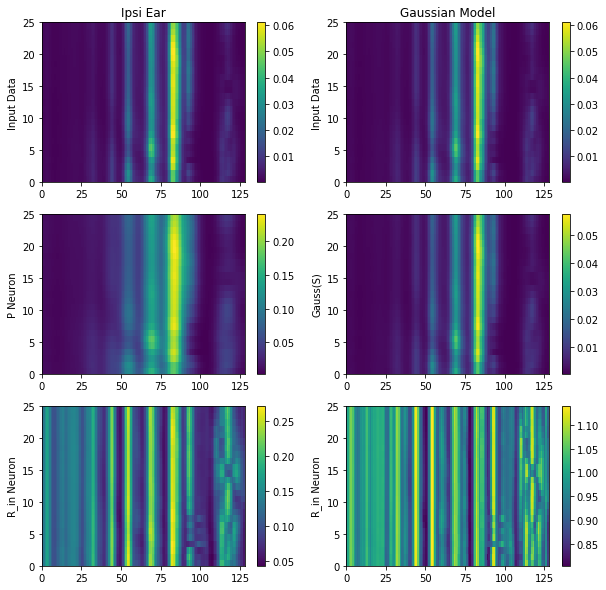

In [32]:
fig = plt.figure(figsize=(10,10))

axs = fig.subplots(nrows=3,ncols=2,squeeze=False)

i_sound = 0
filter_sigma = 1

input_ = np.squeeze(input_i[sounds_types[i_sound],:,:])

ax = axs[0,0]
ax.set_title('Ipsi Ear')
tmp1 = input_
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Input Data')
fig.colorbar(a,ax=ax)

ax = axs[0,1]
ax.set_title('Gaussian Model')
tmp1 = input_
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Input Data')
fig.colorbar(a,ax=ax)



ax = axs[1,0]
tmp1 = np.squeeze(p_in_i[i_sound,:,-1:,:])
a = ax.pcolormesh(tmp1)
ax.set_ylabel('P Neuron')
fig.colorbar(a,ax=ax)

ax = axs[1,1]
tmp1 = input_
tmp1 = gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Gauss(S)')
fig.colorbar(a,ax=ax)



ax = axs[2,0]
tmp1 = np.squeeze((r_in_i[i_sound,:,-1:,:]))
a = ax.pcolormesh(tmp1)
ax.set_ylabel('R_in Neuron')
fig.colorbar(a,ax=ax)

ax = axs[2,1]
tmp1 = input_
tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh(tmp1)
ax.set_ylabel('R_in Neuron')
fig.colorbar(a,ax=ax)


plt.show()


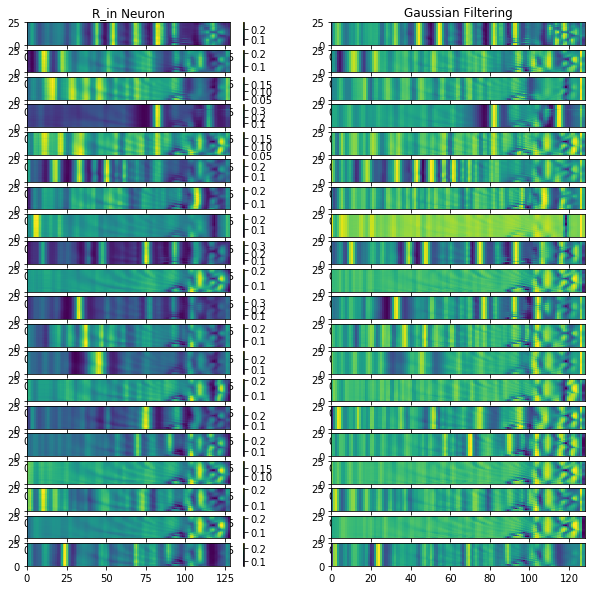

In [33]:
fig = plt.figure(figsize=(10,10))

axs = fig.subplots(nrows=len(sounds_types),ncols=2,squeeze=False)


for i_sounds,sound in enumerate(sounds_types):

    input_ = np.squeeze(input_i[sound,:,:])

    ax = axs[i_sounds,0]
    tmp1 = np.squeeze(r_in_i[i_sounds,:,-1:,:])
    a = ax.pcolormesh(tmp1)
    if i_sounds == 0:
        ax.set_title('R_in Neuron')
    fig.colorbar(a,ax=ax)

    ax = axs[i_sounds,1]
    if i_sounds == 0:
        ax.set_title('Gaussian Filtering')
    tmp1 = input_
    tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=1, mode='nearest', axis=1)
    a = ax.pcolormesh(tmp1)
#     fig.colorbar(a,ax=ax)



plt.show()

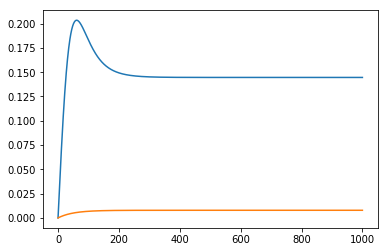

In [34]:
plt.plot(r_in_i[0,0,:,19])
plt.plot(p_in_i[0,0,:,13])
plt.show()